In [158]:
import json
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.special as SciSpecial
from sklearn.linear_model import Lars
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

class StochasticPCE:
    def __init__(self, config):
        
        # Read the JSON config file
        with open(config_file_path, 'r') as json_file:
            loaded_config_data = json.load(json_file)

        self.realization = False
        self.initialized = False
        
        try:
            # Inmport the variables 
            self.X_path = loaded_config_data["X_path"]
            self.X_type = loaded_config_data["X_type"]
            self.Z_type = loaded_config_data["Z_type"]
            self.p_max = loaded_config_data["max_poly_degree"]
            self.q_list = loaded_config_data["q_norm"]

            self.num_Vars = len(self.X_type)
            self.p_list = np.arange(1, self.p_max+1)

            data = sio.loadmat(self.X_path)
            self.X = np.array([data["X"]])[0]
            self.N = len(self.X)  # number of realization 

            # Initialize 
            self.Y = np.array([])
            self.A_trunc = np.array([])
            self.InfoMat = np.array([])
            
            # Checking initialized properly or not 
            self.check_length(np.shape(self.X)[1],self.num_Vars)
            self.check_in_range_type1(max(self.q_list),0 , 1)
            self.check_in_range_type1(min(self.q_list),0 , 1)

            for type_ in self.X_type:
                self.check_type(self.X_type[type_])

            if self.Z_type != []:
                for type_ in self.Z_type: 
                    self.check_type(type_)
                self.stocahstic_solver = True
            else:
                self.stocahstic_solver = False
            
            # If pass the all the checking, then Initialized successfully
            self.initialized = True

            # Display the current setting 
            self.display_line()        
            print("Initialized SPCE successfully")
            if self.stocahstic_solver:
                print("     Using Stochastic PCE solver")
            else:
                print("     Using conventional LAR-PCE solver")
            print("     Input X with shape (N,num_Vars):", np.shape(self.X))
            print("     Input Y with shape (N,1)       :", np.shape(self.Y))
            print("     WARNING, No realization will be inputed when initialize the clase ")
            print("           Please use method: InputRealization() to initialize realization Y")
            print(" ")
            print("     Config information: ")
            print("  ",json.dumps(loaded_config_data, indent=4))
            
        except ValueError as e:
            print(f"    Error from Initialization(): {e}")


    def InputRealization(self, Y):
        self.display_line() 
        print("Input Realization")
        self.check_initialized()
        try:
            self.check_shape(Y, (self.N, 1))
            self.Y = Y
            self.realization = True
            print("Input Realization successfully")
            print("     Input X with shape (N,num_Vars):", np.shape(self.X))
            print("     Input Y with shape (N,1)       :", np.shape(self.Y))

        except ValueError as e:
            print(f"    Error from InputRealization(): {e}")


    def CreateOrderTable(self, poly_degree, q,  plot_ = False):
        self.display_line() 
        print("Create Order-Table")
        try:
            self.check_initialized()
            self.check_in_range_type1(q, 0 , 1)
            self.check_in_range_type3(poly_degree, 1 , self.p_max)

            if self.stocahstic_solver:
                M = self.num_Vars +1 #For unknown var Z
            else:
                M = self.num_Vars
                
            # Define the degrees for each variable: p_array
            p_array = np.arange(poly_degree+1)  # Considering degrees 0, 1, 2, and 3
            # Generate all possible combinations: A
            A = np.array(np.meshgrid(*[p_array]*M)).T.reshape(-1, M)
            A_q = A**q
            A_trunc = A[A_q.sum(axis=1)**(1/q) <= poly_degree]
            self.A_trunc = A_trunc
            
            print("Create Order-Table successfully")
            print(f"    Info: M:{M}, p:{poly_degree}, q:{q}, Shape of Order-Table (cardA, numVars): {np.shape(self.A_trunc)}")

            if plot_:
                # Create a 3D plot
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                ax.scatter(A_trunc[:,0], A_trunc[:,1], A_trunc[:,2], cmap='viridis', edgecolor='k')
                ax.set_xlabel('X-axis')
                ax.set_ylabel('Y-axis')
                ax.set_zlabel('Z-axis')
                ax.set_title('Visualization of First 3 3rd-Order Polynomials')
                plt.show()

            return A_trunc
        
        except ValueError as e:
            print(f"    Error from CreateOrderTable(): {e}")



    def CreateInfoMatrix(self,check_orthonorm = False,show_info_ = False):
        self.display_line() 
        print("Create Information Matrix")

        try:
            #Initialize the information matrix
            self.check_empty_array(self.A_trunc)
            InfoMat = np.ones((self.N, np.shape(self.A_trunc)[0]))

            for dist_type in enumerate(self.X_type.values()):

                i_X = dist_type[0]
                poly_degree = self.A_trunc[:,i_X]
                poly_degree = poly_degree.reshape(-1, 1)
                
                if dist_type[1] == "Uniform":
                    InfoMat_i_X = self.Hilbertian_basis_Legendre(poly_degree,self.X[:,i_X],show_info_)
                elif dist_type[1] == "Gaussian":
                    InfoMat_i_X = self.Hilbertian_basis_Hermite(poly_degree,self.X[:,i_X],show_info_)
                elif dist_type[1] == "Gamma":
                    raise ValueError("Gamma distribution is not avaiable now.")
                else:
                    raise ValueError("Beta distribution is not avaiable now.")

                InfoMat = InfoMat*InfoMat_i_X
    
            self.check_shape(InfoMat,(self.N, np.shape(self.A_trunc)[0]))
            self.InfoMat = InfoMat   
            
            print(f"Create Information Matrix successfully, shape: {np.shape(self.InfoMat)}")
            if check_orthonorm:
                orthonorm_property = np.mean(InfoMat*InfoMat,axis=0)
                print(f"    Checking OrthoNormalization: Min: {np.min(orthonorm_property)}, Max: {np.max(orthonorm_property)}")

            return self.InfoMat

        except ValueError as e:
            print(f"    Error from CreateInfoMatrix(): {e}")

    

    def Solver(self):
        try:
            self.check_realization()
            self.check_empty_array(self.InfoMat)
            
            if self.stocahstic_solver:
                raise ValueError("Stocahstic_solver is not avaiable now.")
            else:
                print("haha")
            
        except ValueError as e:
            print(f"Error from Solver(): {e}")

    

    def hybridLAR_solver(self, return_coeffs = False):
        try:
            # Create a Lars model
            lars_model = Lars()
            # Fit the model to the training data
            lars_model.fit(self.InfoMat, self.Y)
            self.SparseInfoMat = self.InfoMat[:,lars_model.active_]
            coeffs = self.LeastSquare_solver(self.SparseInfoMat)

            if return_coeffs:
                return lars_model.active_, coeffs
            else:
                return lars_model.active_

        except ValueError as e:
            print(f"Error from hybridLAR_solver(): {e}")


    def LAR_solver(self,return_coeffs = False):
        try:
            # Create a Lars model
            lars_model = Lars()
            # Fit the model to the training data
            lars_model.fit(self.InfoMat, self.Y)
            if return_coeffs:
                return lars_model.active_, lars_model.coef_
            else:
                return lars_model.active_

        except ValueError as e:
            print(f"Error from LAR_solver(): {e}")


    def LeastSquare_solver(self,SparseInfoMat = None):
        try:
            # Solving least-square minimization analytically
            if SparseInfoMat is not None:
                coeffs = np.linalg.inv(SparseInfoMat.T @ SparseInfoMat) @ SparseInfoMat.T @ self.Y
                self.check_shape(coeffs,(np.shape(SparseInfoMat)[1],1))
            else:
                coeffs = np.linalg.inv(self.InfoMat.T @ self.InfoMat) @ self.InfoMat.T @ self.Y
                self.check_shape(coeffs,(np.shape(self.A_trunc)[0],1))
            return coeffs

        except ValueError as e:
            print(f"Error from LeastSquare_solver(): {e}")
        




    

    def Hilbertian_basis_Hermite(self, poly_degreee_array, x_values, show_info_ = False):
        """
        - poly_degreee_array have to be shape (card A, 1)
        - x_values have to be shape (N, )
        - output have to be shape (N, card A)
        """
        try:
            self.check_shape(poly_degreee_array, (np.shape(self.A_trunc)[0],1))
            self.check_shape(x_values, (self.N,))
            
            len_A_trunc = len(poly_degreee_array)
            phi = np.empty((len_A_trunc, self.N))
            norm = np.sqrt(SciSpecial.factorial(poly_degreee_array))

            # Expected ouput data should with the shape (N, card A)
            SciSpecial.eval_hermitenorm(poly_degreee_array,x_values,out= phi)
            norm_phi = np.transpose(phi / norm)

            self.check_shape(norm_phi, (self.N,np.shape(self.A_trunc)[0]))
            if show_info_:
                print(f"Create Normalized Hermite basis, shape: {np.shape(norm_phi)}")
            return(norm_phi)

        except ValueError as e:
            print(f"    Error from Hilbertian_basis_Hermite(): {e}")

    def Hilbertian_basis_Legendre(self, poly_degreee_array, x_values, show_info_ = False):
        """
        - poly_degreee_array have to be shape (card A, 1)
        - x_values have to be shape (N, )
        - output have to be shape (N, card A)
        """
        try:
            self.check_shape(poly_degreee_array, (np.shape(self.A_trunc)[0],1))
            self.check_shape(x_values, (self.N,))
            
            len_A_trunc = len(poly_degreee_array)
            phi = np.empty((len_A_trunc, self.N))
            norm = np.sqrt(1/(2*poly_degreee_array+1))

            # Expected ouput data should with the shape (N, card A)
            SciSpecial.eval_legendre(poly_degreee_array,x_values,out= phi)
            norm_phi = np.transpose(phi / norm)

            self.check_shape(norm_phi, (self.N,np.shape(self.A_trunc)[0]))
            if show_info_:
                print(f"Create Normalized Legendre basis, shape: {np.shape(norm_phi)}")
            return(norm_phi)

        except ValueError as e:
            print(f"    Error from Hilbertian_basis_Legendre(): {e}")




        












    def check_realization(self):
        if not self.realization:
            raise ValueError("Error: Realization not properly initialized. Please check self.InputRealization()")

    def check_initialized(self):
        if not self.initialized:
            raise ValueError("Error: Object not properly initialized.")
        
    def check_empty_array(self,arr):
        if np.array_equal(arr, np.array([])):
            raise ValueError("Array cannot be empty.")

    def check_type(self, type_):
        valid_type = {"Uniform", "Gaussian", "Gamma","Beta"}
        if type_ not in valid_type:
            raise ValueError(f"Valid types are {valid_type}, but received '{type_}'.")

    def check_shape(self, array, expected_shape):
        if array.shape != expected_shape:
            raise ValueError(f"Array shape is {array.shape}. Expected shape is {expected_shape}.")

    def check_length(self, len_input, expected_len):
        if len_input != expected_len:
            raise ValueError(f"Input length is {len_input}. Expected length is {expected_len}.")

    def check_in_range_type1(self, variable, lower_limit, upper_limit):
        if not (lower_limit < variable <= upper_limit):
            raise ValueError(f"{variable} is outside the range ({lower_limit}, {upper_limit}].")
    
    def check_in_range_type2(self, variable, lower_limit, upper_limit):
        if not (lower_limit <= variable < upper_limit):
            raise ValueError(f"{variable} is outside the range [{lower_limit}, {upper_limit}).")
    
    def check_in_range_type3(self, variable, lower_limit, upper_limit):
        if not (lower_limit <= variable <= upper_limit):
            raise ValueError(f"{variable} is outside the range [{lower_limit}, {upper_limit}].")
        
    def display_line(self):
        print("-------------------------------------------------------------------------------")
        

In [160]:
import json
import sys
sys.path.append(r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/InputData/")
import numpy as np
import maxTF_SDOF as TF


# Specify the path to your JSON config file
config_file_path = r"C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/config/config.json"

m_t = 100
sigma_m = 10

c_t = 100
sigma_c = 5

lb_k = 4*(np.pi**2)*8000
ub_k = 4*(np.pi**2)*12000
k_t = (lb_k + ub_k) / 2
sigma_k = (ub_k - lb_k) / np.sqrt(12)

mean = np.array([m_t,c_t,k_t])
std  = np.array([sigma_m,sigma_c,sigma_k])


Model = StochasticPCE(config_file_path)

Y = TF.realization_SDOF(Model.X_path, mean, std,)
reshaped_Y = np.reshape(Y, (len(Y), 1))


Model.InputRealization(reshaped_Y)

A = Model.CreateOrderTable(3,1)
poly_degreeA = A[:,0]
poly_degreeA = poly_degreeA.reshape(-1, 1)

poly_degreeB = A[:,1]
poly_degreeB = poly_degreeB.reshape(-1, 1)

poly_degreeC = A[:,2]
poly_degreeC = poly_degreeC.reshape(-1, 1)

Model.X[:,0] = Model.X[:,0].reshape(1,-1)

#print(poly_degree)
#print(Model.X[:,0])

#A = Model.Hilbertian_basis_Hermite(poly_degreeA,Model.X[:,0])
#B = Model.Hilbertian_basis_Hermite(poly_degreeB,Model.X[:,1])
#C = Model.Hilbertian_basis_Legendre(poly_degreeC,Model.X[:,2])

X = Model.CreateInfoMatrix(True,True)

print(Model.hybridLAR_solver())
print(Model.LAR_solver())
print(Model.LeastSquare_solver().T)

#check normalized
#print(np.mean(A*A,axis=0))
#print(np.mean(B*B,axis=0))
#print(np.mean(C*C,axis=0))
#print(np.mean(A*C,axis=0))
#print(np.mean(B*C,axis=0))



#y_alpha = np.linalg.inv(X.T @ X) @ X.T @ Model.Y
#print(y_alpha)
#
#
#
## Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, Model.Y, test_size=0.2, random_state=42)
#
## Create a Lars model
#lars_model = Lars()
#
## Fit the model to the training data
#lars_model.fit(X_train, y_train)
#
#print(lars_model.coef_)
#print(lars_model.active_)
##reg.coef_[reg.coef_ > 3] = 0
## Make predictions on the test set
#predictions = lars_model.predict(X_test)
#
## Evaluate the model
#mse = mean_squared_error(y_test, predictions)
##print(f"Mean Squared Error: {mse}")










-------------------------------------------------------------------------------
Initialized SPCE successfully
     Using conventional LAR-PCE solver
     Input X with shape (N,num_Vars): (500, 3)
     Input Y with shape (N,1)       : (0,)
     WARNING, No realization will be inputed when initialize the clase 
           Please use method: InputRealization() to initialize realization Y
 
     Config information: 
   {
    "X_path": "C:/Users/v196m/Desktop/master_project/Masterarbeit/StochasticPCE/InputData/samples_500.mat",
    "X_type": {
        "x1": "Gaussian",
        "x2": "Gaussian",
        "x3": "Uniform"
    },
    "Z_type": [],
    "max_poly_degree": 5,
    "q_norm": [
        0.25,
        0.5,
        0.75,
        1
    ]
}
-------------------------------------------------------------------------------
Input Realization
Input Realization successfully
     Input X with shape (N,num_Vars): (500, 3)
     Input Y with shape (N,1)       : (500, 1)
------------------------------

c:\Users\v196m\anaconda3\envs\opt2\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
c:\Users\v196m\anaconda3\envs\opt2\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavi

[  1.   2.   6.  24. 120.]
106.28273690907176
122.77340351645014
104.57160108980396


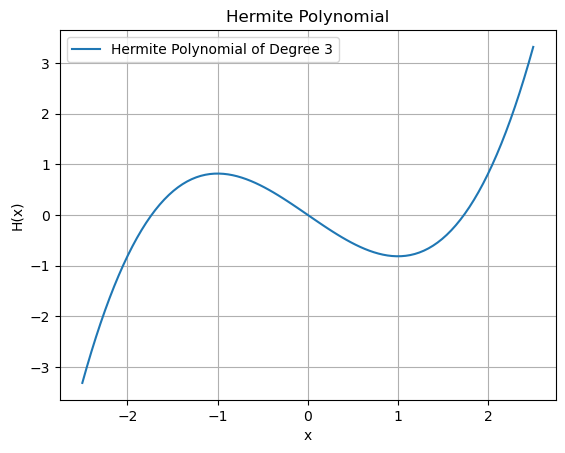

In [28]:
from scipy import special


import numpy as np
import matplotlib.pyplot as plt

# Define the degree of the Hermite polynomial
degree = 3
a = np.array([1,2,3,4,5])
print(special.factorial(a))

# Generate x values
x_values = np.linspace(-1, 1, 100)
legendre_values = special.eval_legendre(3,x_values)/np.sqrt(1/(2*3+1))




# Expected ouput data should with the shape (N, card A)
x_values_ = np.linspace(-2.5, 2.5, 100)
hermite_values = SciSpecial.eval_hermitenorm(3,x_values_)/np.sqrt(SciSpecial.factorial(3))

print(np.dot(legendre_values,legendre_values))
print(np.dot(hermite_values,hermite_values))
print(np.dot(hermite_values,legendre_values))


# Plot the Hermite polynomial
plt.plot(x_values_, hermite_values, label=f'Hermite Polynomial of Degree {degree}')
plt.xlabel('x')
plt.ylabel('H(x)')
plt.legend()
plt.title('Hermite Polynomial')
plt.grid(True)
plt.show()



In [137]:
from sklearn.linear_model import Lars
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Create a synthetic dataset for demonstration
X, y = make_regression(n_samples=500, n_features=13, noise=0.1, random_state=42)

print(np.shape(X))
print(np.shape(y))
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Lars model
lars_model = Lars()

# Fit the model to the training data
lars_model.fit(X_train, y_train)

print(lars_model.coef_)
print(lars_model.active_)
#reg.coef_[reg.coef_ > 3] = 0
# Make predictions on the test set
predictions = lars_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")


(500, 13)
(500,)
[ 9.78443400e+01  9.21543567e+01  1.06660942e+00  3.32996748e+01
 -2.26949936e-04  2.16185868e+01 -9.51654821e-03  6.22688877e+01
  6.69425494e+01  9.13294148e+01 -5.17184641e-03  5.90857821e+01
  7.97801420e+01]
[9, 0, 12, 1, 11, 7, 8, 3, 5, 2, 6, 10, 4]
Mean Squared Error: 0.011728225435527283


c:\Users\v196m\anaconda3\envs\opt2\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
